## Adding new emission data: global

Once you have a **DELWAQ** model, you may want to update your model in order to add new emission data, add sample locations, use different hydrological forcing data, create and run different scenarios etc.

With HydroMT, you can easily read your model and update one or several components of your model using the **update** function of the command line interface (CLI). Here are the steps and some examples on how to **update and add global emission data to your model**.

All lines in this notebook which starts with ! are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste them in your shell to get more feedback.

### Import packages

In this notebook, we will use some functions of HydroMT to prepare hydroMT configuration and library file and plot the new emission data of the updated model. Here are the libraries to import to realize these steps.

In [1]:
import numpy as np

In [2]:
# for plotting
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
proj = ccrs.PlateCarree() # plot projection

In [3]:
# import hydromt
import hydromt

In [4]:
# setup logging
from  hydromt.log import setuplog
logger = setuplog("update_model_emission", log_level=10)

2021-07-21 16:41:31,830 - update_model_emission - log - INFO - HydroMT version: 0.4.0


### hydroMT CLI update interface

Using the `hydroMT update` API, we can update one or several components of an already existing DELWAQ model. Let's get an overview of the available options:

In [5]:
# Print the options available from the update command
! hydromt update --help

Usage: hydromt update [OPTIONS] MODEL MODEL_ROOT

  Update a specific component of a model. Set an output directory to copy
  the edited model to a new folder, otherwise maps are overwritten.

  Example usage:
  --------------

  Update (overwrite) landuse-landcover maps in a wflow model
  hydromt update wflow /path/to/model_root -c setup_lulcmaps --opt source_name=vito

  Update reservoir maps based on default settings in a wflow model and write to new directory
  hydromt update wflow /path/to/model_root -o /path/to/model_out -c setup_reservoirs

Options:
  -o, --model-out DIRECTORY  Output model folder. Maps in MODEL_ROOT are
                             overwritten if left empty.

  -c, --components TEXT      Model components from ini file to run
  --opt TEXT                 Component specific keyword arguments, see the
                             setup_<component> method of the specific model
                             for more information about the arguments.

  -i, --config PA

### Adding global data to the model

Using HydroMT, it is quite easy to add additional emission data from already available global data. Here we will see an example where we **add a cattle map (glw_cattle)** from the [GLW 3](https://dataverse.harvard.edu/dataverse/glw_3) data.

You can see a list of all readily available data in HydroMT in the [docs](https://deltares.github.io/hydromt/latest/user_guide/data.html#available-global-datasets).

In [6]:
#Let's see what are the attributes of the glw_cattle data source
data_catalog = hydromt.DataCatalog(logger=logger)
data_catalog["glw_cattle"]

2021-07-21 16:41:33,853 - update_model_emission - data_adapter - INFO - Downloading file to /home/runner/.hydromt_data/data/v0.0.2/data.tar.gz


2021-07-21 16:41:34,527 - update_model_emission - data_adapter - DEBUG - Unpacking data from /home/runner/.hydromt_data/data/v0.0.2/data.tar.gz


2021-07-21 16:41:35,701 - update_model_emission - data_adapter - INFO - Updating data sources from yml file /home/runner/.hydromt_data/data/v0.0.2/data_catalog.yml


{'category': 'socio economic',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.7910/DVN/GIVQ75',
 'paper_ref': 'Gilbert at al (2018)',
 'path': '/home/runner/.hydromt_data/data/v0.0.2/glw_cattle.tif',
 'source_author': 'glw (Gridded Livestock of World 3 Dataverse)',
 'source_license': 'CC 4.0',
 'source_url': 'https://dataverse.harvard.edu/dataverse/glw_3',
 'source_version': 'GLW 3, last downloaded 2020-06-11'}

Here we can see that our cattle grid is a raster *.tif* file. The important properties for hydroMT are:

* **path**: path to where the data is stored.
* **data_type**: `HydroMT DataCatalog type` either *RasterDataset* (gridded data), *GeoDataFrame* (vector data) or *GeoDataset* (point timeseries). Our file is a gridded tif file so *RasterDataset*.
* **driver**: driver used to open the data. Either *raster* (GDAL compliant raster file), *netcdf* (NetCDF file), *zarr* (zarr file) or *vector* (GDAL compliant vector file). Our file is a tif raster so *raster*.

The rest are just additional **meta** information on the data source. You can notice that the **crs** property is not mentionned. This is because this data source has the same crs as the default hydroMT one EPS*4326*.

### Preparing the configuration file

As the **glw_cattle** data is a **raster** data, we will add it to our model using the `[setup_emission_raster]` component of hydroMT Delwaq.

Let's prepare a **HydroMT configuration file** with our options for preparing the cattle emission raster. All available options are available in the [docs(setup_emission_raster)](https://deltares.github.io/hydromt_delwaq/latest/generated/hydromt_delwaq.delwaq.DelwaqModel.setup_emission_raster.html).

In [7]:
# Dictionnary with all the components and options we want to update
emission_raster_options = {
    'global' : {'mtype': 'EM'},
    'setup_emission_raster': {
        'emission_fn': 'glw_cattle',
        'scale_method': 'average',
        'fillna_method': 'zero',
        'area_division': True
    },
}

# Save it to a hydroMT ini file
fn_ini = "delwaq_update_emission_cattle.ini"
hydromt.config.configwrite(fn_ini, emission_raster_options)

# Open the file and visualize the content
with open(fn_ini, 'r') as f:
    txt = f.read()
print(txt)

[global]
mtype = EM

[setup_emission_raster]
emission_fn = glw_cattle
scale_method = average
fillna_method = zero
area_division = True




Some explanations about the option we chose here:

* **emission_fn**: name of the cattle data source in hydroMT Data Catalog.
* **scale_method**: method for resampling from the data resolution (10km*10km for GLW) to the model resolution (5km*5km, same as the wflow_piave model resolution). Available methods are *nearest*, *average*, *mode* (for classification).
* **fillna_method**: method to fill NaN values in the data sources either *nearest*, *zero* or *value* to fill with a user defined value.
* **area_division**: if needed do the resampling in head/m2 (True) instead of head (False). The GLW cattle grid presents the number of cows per grid cell. To resample to a different grid resolution, we need to resample cow densities instead. After resampling, the cattle grid will be again in cows per model grid cell.

### Updating the model with the cattle grid

In [8]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt update delwaq EM_piave -o ./EM_piave_extended -i delwaq_update_emission_cattle.ini -vv

2021-07-21 16:41:37,422 - update - log - DEBUG - Writing log messages to new file /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended/hydromt.log.
2021-07-21 16:41:37,422 - update - log - INFO - HydroMT version: 0.4.0
2021-07-21 16:41:37,422 - update - main - INFO - Updating delwaq model at /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave (r).
2021-07-21 16:41:37,422 - update - main - INFO - Output dir: /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended
2021-07-21 16:41:37,422 - update - main - INFO - User settings:
2021-07-21 16:41:37,423 - update - cli_utils - INFO - global.mtype: EM
2021-07-21 16:41:37,423 - update - cli_utils - INFO - setup_emission_raster.emission_fn: glw_cattle
2021-07-21 16:41:37,423 - update - cli_utils - INFO - setup_emission_raster.scale_method: average
2021-07-21 16:41:37,423 - update - cli_utils - INFO - setup_emission_raster.fillna_method: zero
2021-07

2021-07-21 16:41:37,522 - update - delwaq - INFO - Read staticmaps from /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave/staticdata/staticmaps.nc
2021-07-21 16:41:37,531 - update - delwaq - INFO - Model read
2021-07-21 16:41:37,541 - update - model_api - DEBUG - setup_emission_raster.emission_fn: glw_cattle
2021-07-21 16:41:37,542 - update - model_api - DEBUG - setup_emission_raster.scale_method: average
2021-07-21 16:41:37,542 - update - model_api - DEBUG - setup_emission_raster.fillna_method: zero
2021-07-21 16:41:37,542 - update - model_api - DEBUG - setup_emission_raster.fillna_value: 0.0
2021-07-21 16:41:37,542 - update - model_api - DEBUG - setup_emission_raster.area_division: True
2021-07-21 16:41:37,542 - update - data_adapter - INFO - Updating data sources from yml file /home/runner/.hydromt_data/data/v0.0.2/data_catalog.yml


2021-07-21 16:41:37,606 - update - delwaq - INFO - Preparing 'glw_cattle' map.
2021-07-21 16:41:37,616 - update - data_adapter - INFO - DataCatalog: Getting glw_cattle RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.2/glw_cattle.tif
2021-07-21 16:41:37,630 - update - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.775, 45.808, 12.742, 46.692]


2021-07-21 16:41:37,660 - update - emissions - INFO - Deriving None using average resampling (nodata=-1.7e+308).
2021-07-21 16:41:37,685 - update - delwaq - INFO - Write model data to /home/runner/work/hydromt_delwaq/hydromt_delwaq/docs/examples/examples/EM_piave_extended


2021-07-21 16:41:37,700 - update - delwaq - INFO - Writing staticmap files.


2021-07-21 16:41:37,756 - update - delwaq - INFO - Writing model staticgeom to file.
2021-07-21 16:41:37,772 - update - delwaq - INFO - Writing hydromap files.


2021-07-21 16:41:37,840 - update - delwaq - WARNING - Warning: no dynamic map, skipping write_dynamicmaps.


The example above means the following: run **hydromt** with:

- `update delwaq`: i.e. update a delwaq model
- `EM_piave`: original model folder
- `-o ./EM_piave_extended`: output updated model folder
- `-i delwaq_update_emission_cattle.ini`: hydroMT configuration file containing the components and options to update
- `-v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

### Visualization of the new emission map

We can now plot our newly created cattle grid.

In [9]:
# Load the original and updated model with hydromt
mod = hydromt.DelwaqModel(root='EM_piave_extended', mode='r')

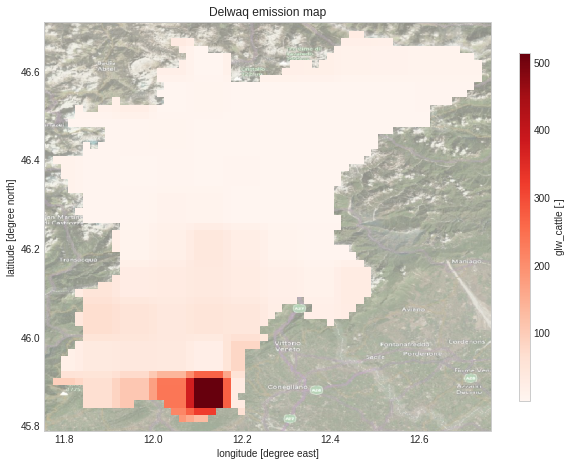

In [10]:
# Edit the lines below to change the emission map and its colormap
emissionmap = 'glw_cattle'
colormap = 'Reds'

#Load the emission map
da = mod.staticmaps[emissionmap].raster.mask_nodata()
da.attrs.update(long_name=emissionmap, units='-')

#Plot
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot emission map
cmap = plt.cm.get_cmap(colormap)
kwargs = dict(cmap=cmap)
# plot 'normal' elevation
da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Delwaq emission map")